In [1]:
import healpy as hp
import numpy as np
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
from astropy.io import fits
import time
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pprint
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from astropy.coordinates import spherical_to_cartesian
from reproject import reproject_interp
import sys
from itertools import compress
from pprint import pprint

from mocpy import MOC
from mocpy import WCS as mocWCS

from billiard.pool import Pool
import multiprocessing
from functools import partial
from multiprocessing import SimpleQueue

import pickle

In [2]:
# Get files
tess_filename = 'tess2019359002923-s0020-1-1-0165-s_ffic.fits'
ps1_filename = 'ds9.fits'
folder = './data/'


tess_data = None
tess_wcs = None
tess_poly = None
with fits.open(folder + tess_filename) as tess_hdul:
    tess_data = tess_hdul[1].data
    tess_wcs = WCS(tess_hdul[1].header)
    tess_poly = tess_wcs.calc_footprint()

ps1_data = None
ps1_wcs = None
ps1_poly = None
with fits.open(folder + ps1_filename) as ps1_hdul:
    # ps1_hdul.info()
    ps1_data = ps1_hdul[0].data
    ps1_wcs = WCS(ps1_hdul[0].header)
    ps1_poly = ps1_wcs.calc_footprint()
    # print(ps1_hdul[0].header)
print(ps1_poly)

print("TESS dimensions: %s, %s" % np.shape(tess_data))
print("\tTESS polygon: %s" % tess_poly)

print("\nPS1 SkyCell dimensions: %s, %s" % np.shape(ps1_data))
print("\tPS1 SkyCell polygon: %s" % ps1_poly)

min_ps1_ra = np.min(ps1_poly[:,0])
max_ps1_ra = np.max(ps1_poly[:,0])

min_ps1_dec = np.min(ps1_poly[:,1])
max_ps1_dec = np.max(ps1_poly[:,1])

print("\n")
print(min_ps1_ra, max_ps1_ra)
print(min_ps1_dec, max_ps1_dec)

print("****************************")

ps1_platescale = 0.258 # arcsec/pixel
ps1_ps_deg = ps1_platescale/3600.
ps1_pix_area_sq_deg = ps1_ps_deg**2
print("\nArea per PS1 pixel: %s deg^2" % ps1_pix_area_sq_deg)

# super sample PS1 pixels
PS1_NSIDE=2097152
ps1_hp_area_sq_deg = hp.nside2pixarea(nside=PS1_NSIDE, degrees=True)
print("Area per PS1 NSIDE %s pixel: %s deg^2" % (PS1_NSIDE, ps1_hp_area_sq_deg))
hp_per_ps1 = ps1_pix_area_sq_deg/ps1_hp_area_sq_deg
print("PS1 NSIDE pixels per native PS1 pixel: %s" % hp_per_ps1)



tess_platescale = 21.0 # arcsec/pixel
tess_ps_deg = tess_platescale/3600.
tess_pix_area_sq_deg = tess_ps_deg**2
print("\nArea per TESS pixel: %s deg^2" % tess_pix_area_sq_deg)

# super sample TESS pixels
TESS_NSIDE = 32768
tess_hp_pixel_area = hp.nside2pixarea(nside=TESS_NSIDE, degrees=True)
print("Area per TESS NSIDE %s pixel: %s deg^2" % (TESS_NSIDE, tess_hp_pixel_area))
hp_per_tess = tess_pix_area_sq_deg/tess_hp_pixel_area
print("TESS NSIDE pixels per native TESS pixel: %s" % hp_per_tess)

indices_per_tess = tess_pix_area_sq_deg/ps1_hp_area_sq_deg
print("\nPS1 NSIDE pixel per TESS pixel: %s" % indices_per_tess)


print("\nPS1 footprint")
print(ps1_wcs.calc_footprint())

[[120.42647355  44.75012604]
 [120.44436166  45.18629423]
 [119.82360306  45.1971815 ]
 [119.810496    44.76084589]]
TESS dimensions: 2078, 2136
	TESS polygon: [[130.6751069   48.53119395]
 [125.5915372   37.65167451]
 [110.23965038  40.44681297]
 [113.0104184   52.19987997]]

PS1 SkyCell dimensions: 6289, 6307
	PS1 SkyCell polygon: [[120.42647355  44.75012604]
 [120.44436166  45.18629423]
 [119.82360306  45.1971815 ]
 [119.810496    44.76084589]]


119.8104959965494 120.44436165778134
44.750126038309155 45.19718149781265
****************************

Area per PS1 pixel: 5.136111111111111e-09 deg^2
Area per PS1 NSIDE 2097152 pixel: 7.816531185164738e-10 deg^2
PS1 NSIDE pixels per native PS1 pixel: 6.570831727581554

Area per TESS pixel: 3.402777777777778e-05 deg^2
Area per TESS NSIDE 32768 pixel: 3.201651173443477e-06 deg^2
TESS NSIDE pixels per native TESS pixel: 10.628196494366946

PS1 NSIDE pixel per TESS pixel: 43533.09284092701

PS1 footprint
[[120.42647355  44.75012604]
 [120.444

Set MJD-END to 58842.046135 from DATE-END'. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [3]:
# Ravel tess pixels from 2D -> 1D
t_y, t_x = np.shape(tess_data)
ty, tx = np.mgrid[:t_y, :t_x]

print(ty)

ty_input = ty.ravel()
tx_input = tx.ravel()

print(np.shape(tess_data))
print(len(tx_input))
tpix_coord_input = np.asarray([ty_input, tx_input]).T


[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [2075 2075 2075 ... 2075 2075 2075]
 [2076 2076 2076 ... 2076 2076 2076]
 [2077 2077 2077 ... 2077 2077 2077]]
(2078, 2136)
4438608


In [4]:
start = time.time()

# define TESS pixels as polygons
tess_pixel_vertices = []
tess_pix_centers = []
tess_pix_center_ra = []
tess_pix_center_dec = []

for i, c in enumerate(tpix_coord_input):
    y = c[0]
    x = c[1]

    _ra, _dec = tess_wcs.all_pix2world(x, y, 0)
    
    # Sanity - only process pixels within a PS1 footprint for now:
    if not (_ra >= min_ps1_ra and _ra < max_ps1_ra and _dec >= min_ps1_dec and _dec < max_ps1_dec):
        continue

    tess_pix_centers.append([_ra, _dec])
    tess_pix_center_ra.append(_ra)
    tess_pix_center_dec.append(_dec)
    
    # We want pixel polygons defined as:

    # (x1-dx,y1-dy) ...... (x1+dx,y1-dy)
    #  .
    #  .
    #  .
    # (x1-dx,y1+dy) ...... (x1+dx,y1+dy)

    # => 
    
    # [ 
    #   [x1-dx, y1-dy],
    #   [x1+dx, y1-dy],
    #   [x1+dx, y1+dy],
    #   [x1-dx, y1+dy],
    # ]

    upper_left = (x-0.5, y-0.5)
    upper_right = (x+0.5, y-0.5)
    lower_right = (x+0.5, y+0.5)
    lower_left = (x-0.5, y+0.5)

    t_poly = tess_wcs.all_pix2world([upper_left, upper_right, lower_right, lower_left], 0)
    tess_pixel_vertices.append(t_poly)
    # tess_pix_dict[i] = t_poly



print("Number of TESS pixels: %s" % len(tess_pixel_vertices))
# print(tess_pixel_vertices)

print('\nTime taken:', time.time() - start)

Number of TESS pixels: 6125

Time taken: 29.495346784591675


In [5]:
# Ravel PS1 pixels from 2D -> 1D
start = time.time()

p_y, p_x = np.shape(ps1_data)
print(np.shape(ps1_data))

py, px = np.mgrid[:p_y, :p_x]

py_input = py.ravel()
px_input = px.ravel()

ppix_coord_input = np.asarray([py_input, px_input]).T

x2 = ppix_coord_input[:,1]
y2 = ppix_coord_input[:,0]
_ra2, _dec2 = ps1_wcs.all_pix2world(x2, y2, 0)

print('\nTime taken:', time.time() - start)

(6289, 6307)

Time taken: 2.6421360969543457


In [6]:
# Get TESS pixels enclosed by the PS1 footprint.

start = time.time()

ps1_skycoord = SkyCoord(ps1_poly, unit="deg", frame="icrs")
ps1_moc = MOC.from_polygon_skycoord(ps1_skycoord, complement=False, max_depth=21)

ps1_mask = ps1_moc.contains_lonlat(tess_pix_center_ra*u.degree, tess_pix_center_dec*u.degree)
print("Num pix enc: %s" % ps1_mask.sum())

enc_tess_pix_vertices = list(compress(tess_pixel_vertices, ps1_mask))
enc_tess_pix_center_ra = np.asarray(tess_pix_center_ra)[ps1_mask]
enc_tess_pix_center_dec = np.asarray(tess_pix_center_dec)[ps1_mask]

enc_tess_pix = []
for t in enc_tess_pix_vertices:
    tess_pix_skycoord = SkyCoord(t, unit="deg", frame="icrs")
    tess_pix_moc = MOC.from_polygon_skycoord(tess_pix_skycoord, complement=False, max_depth=21)
    enc_tess_pix.append(tess_pix_moc)
    
print('\nTime taken:', time.time() - start)

Num pix enc: 5831

Time taken: 4.703273057937622


In [ ]:
# # Resolve PS1 pixels into their TESS pixels
# # ORIGINAL

# start = time.time()

# Nproc=int(multiprocessing.cpu_count()-2) ## I like to reserve 2 CPUs to do other things

# def initialize_moc_pixel(tess_pix_obj, ps1_pixel_ras, ps1_pixel_decs):
    
#     tess_pix_index = tess_pix_obj[0]
#     tess_pix_moc = tess_pix_obj[1]
#     enc_ps1_pix_mask = tess_pix_moc.contains_lonlat(ps1_pixel_ras*u.degree, ps1_pixel_decs*u.degree)
    
#     return (tess_pix_index, ps1_pixel_ras[enc_ps1_pix_mask], ps1_pixel_decs[enc_ps1_pix_mask])

# tess_pix_payload = [(i,etp) for (i,etp) in enumerate(enc_tess_pix)]
# run_init = partial(initialize_moc_pixel, ps1_pixel_ras=_ra2, ps1_pixel_decs=_dec2)

# pix_output = None
# with Pool(processes=Nproc) as pool:
#     pix_output = pool.map(run_init, tess_pix_payload)

# print(len(pix_output))

# print('\nTime taken:', time.time() - start)

In [ ]:
# Resolve PS1 pixels into their TESS pixels
start = time.time()

def init_pool(ps1_pixel_ras, ps1_pixel_decs, _tess_pixel_vertices): # shared_queue, 
    global pix_ras 
    global pix_decs 
    global tess_poly
 
    pix_ras = ps1_pixel_ras
    pix_decs = ps1_pixel_decs
    tess_poly = _tess_pixel_vertices
 
    print("\nInitialized pool!")

Nproc=int(multiprocessing.cpu_count()-2) ## I like to reserve 2 CPUs to do other things
print("Num processes: %s" % Nproc)

def initialize_moc_pixel(tess_pix_obj):

    global pix_ras
    global pix_decs
    global tess_poly
    
    tess_pix_index = tess_pix_obj[0]
    tess_pix_moc = tess_pix_obj[1]
    tp = tess_poly[tess_pix_index]

    _min_ra = np.min([v[0] for v in tp])-0.005
    _max_ra = np.max([v[0] for v in tp])+0.005

    _min_dec = np.min([v[1] for v in tp])-0.005
    _max_dec = np.max([v[1] for v in tp])+0.005

    search_indices = np.where(np.logical_and(((pix_ras <= _max_ra) & (pix_ras >= _min_ra)), 
                                             ((pix_decs <= _max_dec) & (pix_decs >= _min_dec))))[0]

    # print("\nNum in neighborhood: %s" % len(search_indices))
    
    enc_ps1_pix_mask = tess_pix_moc.contains_lonlat(pix_ras[search_indices]*u.degree, pix_decs[search_indices]*u.degree)

    return (tess_pix_index, np.asarray(pix_ras[search_indices])[enc_ps1_pix_mask], np.asarray(pix_decs[search_indices])[enc_ps1_pix_mask])


tess_pix_payload = [(i,etp) for (i,etp) in enumerate(enc_tess_pix)]

pix_output = []
with Pool(processes=Nproc, initializer=init_pool, initargs=(_ra2, _dec2, enc_tess_pix_vertices)) as pool:
    pix_output = pool.map(initialize_moc_pixel, tess_pix_payload)

print("\n Length of output: %s" % len(pix_output))

print('\nTime taken:', time.time() - start)

Num processes: 10

Initialized pool!

Initialized pool!

Initialized pool!

Initialized pool!

Initialized pool!

Initialized pool!

Initialized pool!

Initialized pool!

Initialized pool!

Initialized pool!


In [10]:
# start = time.time()

# pix_output2 = []

# tess_pix_payload = [(i,etp) for (i,etp) in enumerate(enc_tess_pix)]
# for tess_pix_obj in tess_pix_payload:
    
#     tess_pix_index = tess_pix_obj[0]
#     tess_pix_moc = tess_pix_obj[1]
#     tp = enc_tess_pix_vertices[tess_pix_index]

#     _min_ra = np.min([v[0] for v in tp])-0.01
#     _max_ra = np.max([v[0] for v in tp])+0.01

#     _min_dec = np.min([v[1] for v in tp])-0.01
#     _max_dec = np.max([v[1] for v in tp])+0.01

#     search_indices = np.where(np.logical_and(((_ra2 <= _max_ra) & (_ra2 >= _min_ra)), 
#                                              ((_dec2 <= _max_dec) & (_dec2 >= _min_dec))))[0]

#     enc_ps1_pix_mask = tess_pix_moc.contains_lonlat(_ra2[search_indices]*u.degree, _dec2[search_indices]*u.degree)

#     pix_output2.append((tess_pix_index, np.asarray(_ra2[search_indices])[enc_ps1_pix_mask], np.asarray(_dec2[search_indices])[enc_ps1_pix_mask]))
    

# print("\n Length of output: %s" % len(pix_output))
# print('\nTime taken:', time.time() - start)


 Length of output: 5831

Time taken: 451.00049471855164


In [ ]:
start = time.time()

# Plot this for a random TESS pixel ('index_of_pix')

fig = plt.figure(111, figsize=(10, 10))

outer_index_of_pix = 1254
print("Outer index: %s" % outer_index_of_pix)



_enc_ps1_pix = pix_output[outer_index_of_pix]

index_of_pix = _enc_ps1_pix[0]
print("Inner index: %s" % index_of_pix)

_enc_ras = _enc_ps1_pix[1]
_enc_decs = _enc_ps1_pix[2]

# print(_enc_ras)
# print(_enc_decs)

# Define a astropy WCS easily
with mocWCS(
    fig,
    fov=0.008 * u.degree,
    center=SkyCoord(enc_tess_pix_center_ra[index_of_pix], enc_tess_pix_center_dec[index_of_pix], unit="deg", frame="icrs"), 
    coordsys="icrs",
    rotation=Angle(0, u.degree),
    # The gnomonic projection transforms great circles into straight lines.
    projection="TAN"
) as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs) # wcs

    ps1_moc.border(ax=ax, wcs=wcs, alpha=1, color="green")
    
    # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
    enc_tess_pix[index_of_pix].fill(ax=ax, wcs=wcs, alpha=1.0, fill=False, color="red", linewidth=1)

    
    for ___r, ___d in zip(_enc_ras, _enc_decs):
        ax.plot(___r, ___d, 'x', color="blue", markersize=1, transform=ax.get_transform("world"))
    

plt.xlabel("ra")
plt.ylabel("dec")
plt.title("TESS Pixel")
plt.grid(color="black", linestyle="dotted")
plt.show()

print('\nTime taken:', time.time() - start)

In [17]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

/var/folders/h8/qmx4hrv16pj3vtbp14t3d_3m0005pc/T/ipykernel_88827/3973830811.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


Outer index: 0
Inner index: 0
Outer index: 1
Inner index: 1
Outer index: 2
Inner index: 2
Outer index: 3
Inner index: 3
Outer index: 4
Inner index: 4
Outer index: 5
Inner index: 5
Outer index: 6
Inner index: 6
Outer index: 7
Inner index: 7
Outer index: 8
Inner index: 8
Outer index: 9
Inner index: 9
Outer index: 10
Inner index: 10
Outer index: 11
Inner index: 11
Outer index: 12
Inner index: 12
Outer index: 13
Inner index: 13
Outer index: 14
Inner index: 14
Outer index: 15
Inner index: 15
Outer index: 16
Inner index: 16
Outer index: 17
Inner index: 17
Outer index: 18
Inner index: 18
Outer index: 19
Inner index: 19


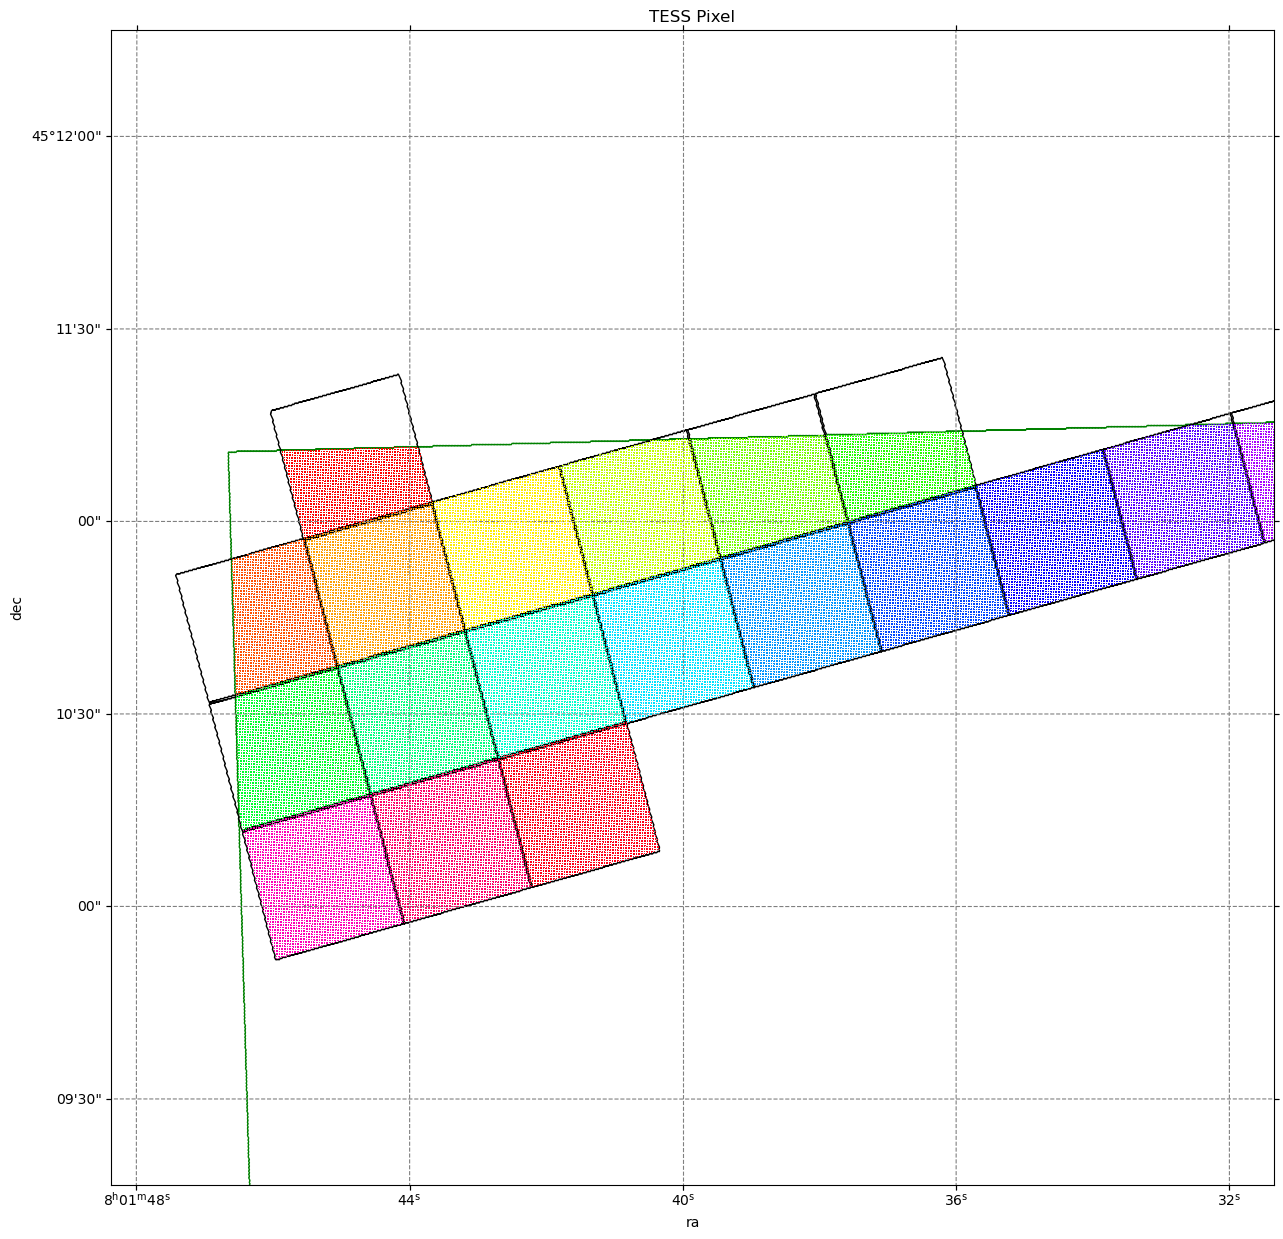


Time taken: 60.15408897399902


In [42]:

start = time.time()

# Plot this for a random TESS pixel ('index_of_pix')

fig = plt.figure(111, figsize=(15, 15))

indices = np.arange(20)
cmap = get_cmap(len(indices))


# get center
avg_ra=0
avg_dec=0
for _ii in indices:

    outer_index_of_pix = _ii
    _enc_ps1_pix = pix_output[outer_index_of_pix]
    index_of_pix = _enc_ps1_pix[0]
    _enc_ras = _enc_ps1_pix[1]
    _enc_decs = _enc_ps1_pix[2]

    

    avg_ra+=(np.average(_enc_ras)/len(indices))
    avg_dec+=(np.average(_enc_decs)/len(indices))

# Define a astropy WCS easily
with mocWCS(
    fig,
    fov=0.0025 * len(indices) * u.degree,
    center=SkyCoord(avg_ra, avg_dec, unit="deg", frame="icrs"), 
    coordsys="icrs",
    rotation=Angle(0, u.degree),
    # The gnomonic projection transforms great circles into straight lines.
    projection="TAN"
) as wcs:

    ax = fig.add_subplot(1, 1, 1, projection=wcs) # wcs
    ps1_moc.border(ax=ax, wcs=wcs, alpha=1, color="green")
        
    for _ii in indices:
    
        outer_index_of_pix = _ii
        print("Outer index: %s" % outer_index_of_pix)
        
        _enc_ps1_pix = pix_output[outer_index_of_pix]
        
        index_of_pix = _enc_ps1_pix[0]
        print("Inner index: %s" % index_of_pix)
        
        _enc_ras = _enc_ps1_pix[1]
        _enc_decs = _enc_ps1_pix[2]
        
        # Call fill with a matplotlib axe and the `~astropy.wcs.WCS` wcs object.
        # enc_tess_pix[index_of_pix].fill(ax=ax, wcs=wcs, alpha=1.0, fill=False, color="red", linewidth=1)
        enc_tess_pix[index_of_pix].border(ax=ax, wcs=wcs, alpha=1.0, fill=False, color="black", linewidth=1)

        clr = cmap(_ii)
        for ___r, ___d in zip(_enc_ras, _enc_decs):
            ax.plot(___r, ___d, ',', color=clr, markersize=10, transform=ax.get_transform("world"))
    

plt.xlabel("ra")
plt.ylabel("dec")
plt.title("TESS Pixel")
plt.grid(color="gray", linestyle="--")
plt.savefig('./tess/TESS_diagnostic.png', dpi=600, bbox_inches = 'tight')

plt.show()

print('\nTime taken:', time.time() - start)

In [41]:
# pprint(pix_output)
# # pprint(pix_output[5:6])
print(len(enc_tess_pix))

tot = 0
for p in pix_output:
    tot += len(p[1])

print(tot)

print(len(_ra2))


# 39897855
# 39664723

5831
39897855
39664723


In [44]:
print(pix_output[4678])

(4678, array([119.85963741, 119.85953947, 119.85944152, ..., 119.85377549,
       119.85387557, 119.85377762]), array([44.8936683 , 44.89366978, 44.89367126, ..., 44.90062941,
       44.90069732, 44.9006988 ]))


In [15]:
with open("./tess/pix_output_list_new.pkl", 'wb') as handle:
    pickle.dump(pix_output, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
np.shape(tess_data)

(2078, 2136)

In [38]:
np.shape(ps1_data)

(6289, 6307)